# "Cross-validation" des modèles

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Hyper-parametres
learning_rate = 0.04
num_epochs = 400
N = 200            #N = 150 a la base
N_cv = 40
seed = 42
batch_size = N//4
#batch_size = N//2
N_test = 0
N_test = 2000      #N_test = 1000 à la base
N_scan = 9
bias = True


p0 = 0.02          #p0 = 0.05 à la base
theta0 = 0
wt = np.pi/20      
theta_std = np.pi/6



## Creer des données synthetiques 

In [3]:
def get_data(
            N = N,
            p0 = p0,
            theta0 = theta0,
            wt = wt,
            theta_std = theta_std,
            seed=seed):
    np.random.seed(42)
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p #add lapse rate
    y = np.random.rand(N) < p #generate data
    return theta, p, y

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss()

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2): #-2 ?
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=bias)    
        self.logit0 = torch.nn.Parameter(logit0*torch.ones(1))

    def forward(self, theta):
        out = self.logit0.sigmoid()/2 + (1-self.logit0.sigmoid())*self.linear(theta).sigmoid()
        return out
        

def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                batch_size = batch_size,
                verbose=False):

    logistic_model = LogisticRegressionModel()

    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])

    loader = DataLoader(TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate/len(loader))
    
    for epoch in range(int(num_epochs)):
        losses = []
        for Theta_, labels_ in loader:
            optimizer.zero_grad()
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    return logistic_model, np.mean(losses)

In [5]:
torch.sigmoid(torch.tensor([-3.]))

tensor([0.0474])

In [6]:
%%timeit
theta, p, y = get_data()

23 µs ± 376 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y,verbose=True) 

Iteration: 0 - Loss: 0.85408
Iteration: 12 - Loss: 0.73923
Iteration: 24 - Loss: 0.67157
Iteration: 36 - Loss: 0.61782
Iteration: 48 - Loss: 0.56868
Iteration: 60 - Loss: 0.52693
Iteration: 72 - Loss: 0.49364
Iteration: 84 - Loss: 0.46757
Iteration: 96 - Loss: 0.44680
Iteration: 108 - Loss: 0.43005
Iteration: 120 - Loss: 0.41654
Iteration: 132 - Loss: 0.40534
Iteration: 144 - Loss: 0.39609
Iteration: 156 - Loss: 0.38821
Iteration: 168 - Loss: 0.38161
Iteration: 180 - Loss: 0.37598
Iteration: 192 - Loss: 0.37117
Iteration: 204 - Loss: 0.36704
Iteration: 216 - Loss: 0.36338
Iteration: 228 - Loss: 0.36027
Iteration: 240 - Loss: 0.35759
Iteration: 252 - Loss: 0.35521
Iteration: 264 - Loss: 0.35311
Iteration: 276 - Loss: 0.35127
Iteration: 288 - Loss: 0.34969
Iteration: 300 - Loss: 0.34827
Iteration: 312 - Loss: 0.34713
Iteration: 324 - Loss: 0.34591
Iteration: 336 - Loss: 0.34496
Iteration: 348 - Loss: 0.34413
Iteration: 360 - Loss: 0.34332
Iteration: 372 - Loss: 0.34268
Iteration: 384 - L

In [8]:
with torch.no_grad():
    if bias: print('bias', logistic_model.linear.bias.item())
    print('slope', logistic_model.linear.weight.item())    
    print('p0', torch.sigmoid(logistic_model.logit0).item())


bias -0.03393300316824204
slope 5.876450306469913
p0 0.003802915553292732


loss= 0.3414181179875635


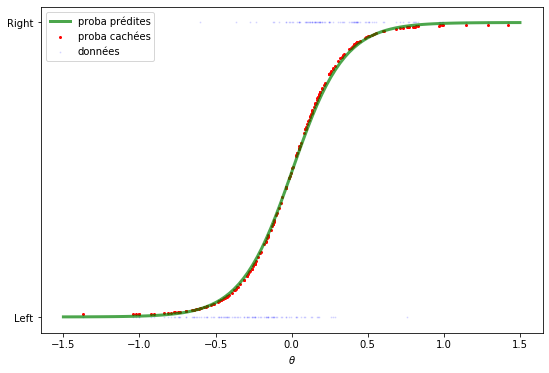

In [9]:
print('loss=', loss)
plt.figure(figsize = (9,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


In [10]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

1.27 s ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## validation

loss= tensor(0.3414, grad_fn=<BinaryCrossEntropyBackward>)


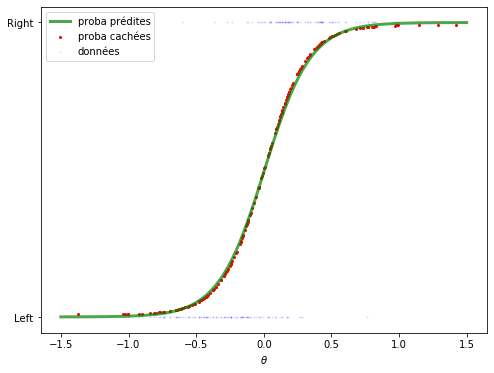

In [11]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();

## influence du nombre de trials

In [ ]:
Ns = np.logspace(1, 3, N_scan, base=10)

Ns_, losses, loss_Ps, loss_P0s = [], [], [], []

for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        P = torch.Tensor(p[:, None])
        
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
    
        loss_P = criterion(outputs, P).item() 
        loss_P0 = criterion(P, P).item()
        
        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        loss_P0s.append(loss_P0)
        Ns_.append(N_)
        loss_Ps.append(loss_P)
        losses.append(loss)
    

N: 10, Loss: 0.46273, loss_P: 0.46665, loss_P0: 0.36047
N: 17, Loss: 0.40873, loss_P: 0.41153, loss_P0: 0.36047
N: 31, Loss: 0.37391, loss_P: 0.37102, loss_P0: 0.36047
N: 56, Loss: 0.36774, loss_P: 0.36292, loss_P0: 0.36047
N: 100, Loss: 0.36814, loss_P: 0.36466, loss_P0: 0.36047
N: 177, Loss: 0.36549, loss_P: 0.36327, loss_P0: 0.36047
N: 316, Loss: 0.36463, loss_P: 0.36200, loss_P0: 0.36047
N: 562, Loss: 0.36480, loss_P: 0.36107, loss_P0: 0.36047


In [ ]:
#plot

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(Ns_, losses, alpha=3/N_cv, label='loss')
ax.scatter(Ns_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(Ns_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # trials')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')

## influence du nombre du learning rate


In [ ]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, loss_Ps, loss_P0s = [], [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)

        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        learning_rates_.append(learning_rate_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

In [ ]:
#influence du learning rate sur loss

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(learning_rates_, losses, alpha=3/N_cv, label='loss')
ax.scatter(learning_rates_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(learning_rates_, loss_P0s, label='loss_P0')
ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))

ax.set_xlabel('learning_rate')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence du nombre d'epochs

In [ ]:
num_epochss = num_epochs * np.logspace(-1, 1, N_scan, base=10)
num_epochss_, losses, loss_Ps, loss_P0s = [], [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        num_epochss_.append(num_epochs_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

In [ ]:
# influence du nbr d'epochs sur loss 
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(num_epochss_, losses, alpha=3/N_cv, label='loss')
ax.scatter(num_epochss_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(num_epochss_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # epochs')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence de la taille du minibatch

In [ ]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, loss_Ps, loss_P0s = [], [], [], []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, batch_size=int(batch_size_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        batch_sizes_.append(batch_size_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

In [ ]:
# influence de la taille du minibatch sur loss 

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(batch_sizes_, losses, alpha=3/N_cv, label='loss')
ax.scatter(batch_sizes_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(batch_sizes_, loss_P0s, label='loss_P0')

ax.set_xlabel(' batch_size')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## Comparaison données générées/données prédites

In [ ]:
## p0 prediction/generate I


In [ ]:

p0s = np.linspace(0, 1, 50)
p0_preds = []


for p0_ in p0s:
    seed_ += 1
    theta, p, y = get_data(p0=p0_, seed=seed_)
    logistic_model, loss = fit_data(theta, y, verbose=False)

    p0_pred =  torch.sigmoid(logistic_model.logit0).item()     
        
    p0_preds.append(p0_pred)
    # print(f"p0 : {p0_pred: .5f}")



In [ ]:
plt.figure(figsize = (8,8)) 
plt.scatter(p0s, p0_s)
plt.xlabel('p0 réel')
plt.ylabel('p0 prédit')


## theta0 prediction/generate 

In [22]:
theta0s = np.random.randn(50)
theta0_preds = []

for theta0_ in theta0s:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)
        
    theta0_pred = logistic_model.linear.bias.item()
    theta0_s.append(theta0_pred)
        
    print(f" theta0: {theta0_pred:.5f}")
    

 theta0: -0.16152
 theta0: -0.16485
 theta0: -0.16223
 theta0: -0.16233
 theta0: -0.16360
 theta0: -0.16230
 theta0: -0.15987
 theta0: -0.15864
 theta0: -0.16305
 theta0: -0.16369
 theta0: -0.15879
 theta0: -0.16358
 theta0: -0.16395
 theta0: -0.16457
 theta0: -0.16507
 theta0: -0.16615
 theta0: -0.16171
 theta0: -0.16205
 theta0: -0.15914
 theta0: -0.16382
 theta0: -0.16391
 theta0: -0.16161
 theta0: -0.16110
 theta0: -0.16513
 theta0: -0.16290
 theta0: -0.16084
 theta0: -0.15967
 theta0: -0.15918
 theta0: -0.16343
 theta0: -0.15971
 theta0: -0.16162
 theta0: -0.16054
 theta0: -0.15934
 theta0: -0.16053
 theta0: -0.16324
 theta0: -0.16263
 theta0: -0.15947
 theta0: -0.16071
 theta0: -0.16047
 theta0: -0.15979
 theta0: -0.15905
 theta0: -0.16185
 theta0: -0.16196
 theta0: -0.16254
 theta0: -0.15756
 theta0: -0.16340
 theta0: -0.16384
 theta0: -0.15808
 theta0: -0.16282
 theta0: -0.16520


Text(0,0.5,'theta prédit')

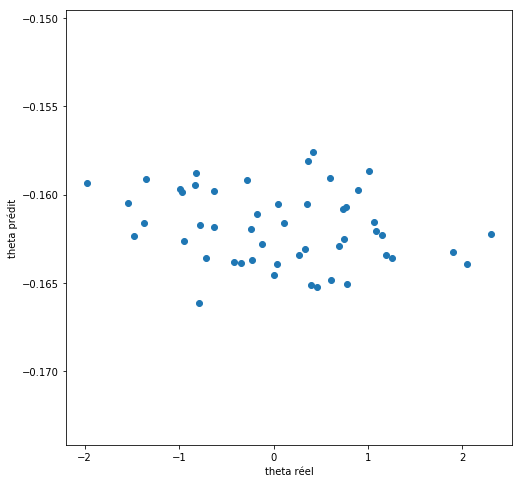

In [23]:
plt.figure(figsize = (8,8)) 
plt.scatter(theta0s, theta0_s)
plt.xlabel('theta réel')
plt.ylabel('theta prédit')


## wt prediction/generate 

In [24]:
wts = np.logspace(-1, 0.1, 50, base=10)
wt_s = []

for wt_ in wts:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)
        
    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        
    wt_pred = logistic_model.linear.weight.item()
        
    wt_s.append(wt_pred)
    print(f" wt:{wt_pred:.5f}")    

 wt:6.10746
 wt:6.22657
 wt:6.17414
 wt:6.17706
 wt:6.20780
 wt:6.13265
 wt:6.16334
 wt:6.19318
 wt:6.18290
 wt:6.20794
 wt:6.17418
 wt:6.14467
 wt:6.11609
 wt:6.16966
 wt:6.12466
 wt:6.11734
 wt:6.14467
 wt:6.17025
 wt:6.11488
 wt:6.15034
 wt:6.20706
 wt:6.16539
 wt:6.19795
 wt:6.21226
 wt:6.12615
 wt:6.20547
 wt:6.20441
 wt:6.22145
 wt:6.12022
 wt:6.18305
 wt:6.14489
 wt:6.15362
 wt:6.13807
 wt:6.17001
 wt:6.15173
 wt:6.10600
 wt:6.13939
 wt:6.22393
 wt:6.23284
 wt:6.22984
 wt:6.19039
 wt:6.14562
 wt:6.10974
 wt:6.13751
 wt:6.21262
 wt:6.17160
 wt:6.22168
 wt:6.16541
 wt:6.20311
 wt:6.21907


Text(0,0.5,'pente prédite')

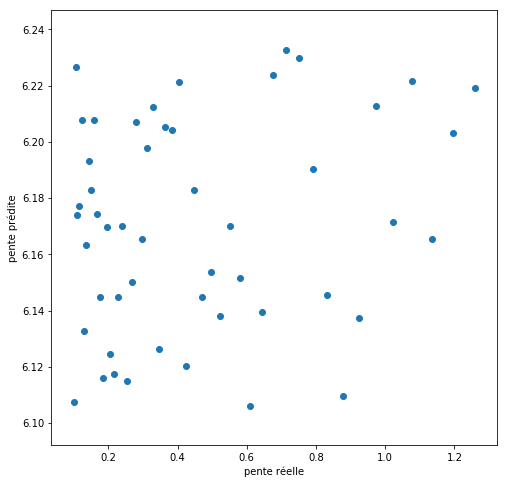

In [25]:
plt.figure(figsize = (8,8)) 
plt.scatter(wts, wt_s)
plt.xlabel('pente réelle')
plt.ylabel('pente prédite')


### Tentative II

p0 :  0.00077
p0 :  0.00166
p0 :  0.00094
p0 :  0.00137
p0 :  0.00085
p0 :  0.00160
p0 :  0.00140
p0 :  0.00098
p0 :  0.00132
p0 :  0.00152
p0 :  0.00060
p0 :  0.00122
p0 :  0.00159
p0 :  0.00130
p0 :  0.00072
p0 :  0.00208
p0 :  0.00183
p0 :  0.00157
p0 :  0.00062
p0 :  0.00168
p0 :  0.00097
p0 :  0.00074
p0 :  0.00189
p0 :  0.00144
p0 :  0.00144
p0 :  0.00139
p0 :  0.00145
p0 :  0.00133
p0 :  0.00164
p0 :  0.00117
p0 :  0.00128
p0 :  0.00152
p0 :  0.00093
p0 :  0.00087
p0 :  0.00115
p0 :  0.00166
p0 :  0.00073
p0 :  0.00132
p0 :  0.00113
p0 :  0.00092
p0 :  0.00098
p0 :  0.00082
p0 :  0.00150
p0 :  0.00171
p0 :  0.00158
p0 :  0.00154
p0 :  0.00085
p0 :  0.00135
p0 :  0.00136
p0 :  0.00156


Text(0,0.5,'p0 prédit')

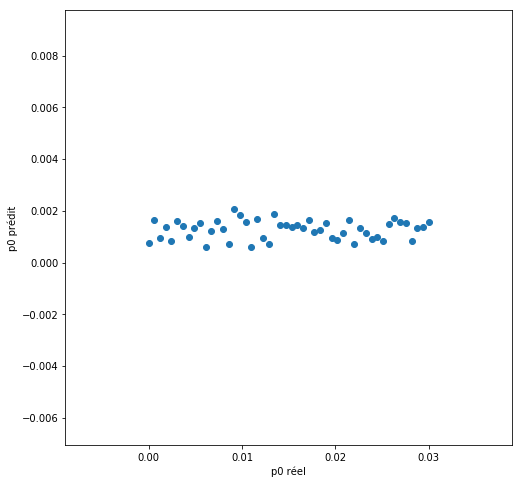

In [26]:
# p0 prediction/generate I

p0s = np.linspace(0,0.03,50)
p0_s = []


for p0_ in p0s:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)

    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
    p0_pred =  torch.sigmoid(logistic_model.logit0).item()     
        
    p0_s.append( p0_pred)
    print(f"p0 : {p0_pred: .5f}")

plt.figure(figsize = (8,8)) 
plt.scatter(p0s, p0_s)
plt.xlabel('p0 réel')
plt.ylabel('p0 prédit')


 theta0: -0.16139
 theta0: -0.16328
 theta0: -0.15879
 theta0: -0.15993
 theta0: -0.16218
 theta0: -0.16198
 theta0: -0.16373
 theta0: -0.16351
 theta0: -0.16292
 theta0: -0.15954
 theta0: -0.16546
 theta0: -0.16308
 theta0: -0.16639
 theta0: -0.16175
 theta0: -0.16363
 theta0: -0.16043
 theta0: -0.16192
 theta0: -0.16546
 theta0: -0.16132
 theta0: -0.16067
 theta0: -0.16282
 theta0: -0.15759
 theta0: -0.16277
 theta0: -0.16401
 theta0: -0.16564
 theta0: -0.16680
 theta0: -0.16110
 theta0: -0.16426
 theta0: -0.15773
 theta0: -0.16246
 theta0: -0.15909
 theta0: -0.16141
 theta0: -0.16324
 theta0: -0.16611
 theta0: -0.15841
 theta0: -0.16410
 theta0: -0.16701
 theta0: -0.16320
 theta0: -0.16116
 theta0: -0.16303
 theta0: -0.16420
 theta0: -0.16383
 theta0: -0.16429
 theta0: -0.16680
 theta0: -0.16299
 theta0: -0.16122
 theta0: -0.16204
 theta0: -0.16174
 theta0: -0.15831
 theta0: -0.16127


Text(0,0.5,'theta prédit')

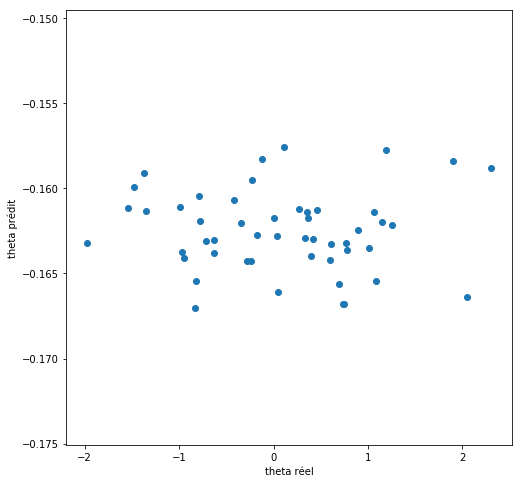

In [27]:
#theta0 prediction/generate 

theta0s = np.random.randn(50) #hum... pas terrible
theta0_s = []

for theta0_ in theta0s:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)

    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        
    theta0_pred = logistic_model.linear.bias.item()
    theta0_s.append(theta0_pred)
        
    print(f" theta0: {theta0_pred:.5f}")
    
plt.figure(figsize = (8,8)) 
plt.scatter(theta0s, theta0_s)
plt.xlabel('theta réel')
plt.ylabel('theta prédit')


 wt:6.22895
 wt:6.22635
 wt:6.13428
 wt:6.18530
 wt:6.17231
 wt:6.21855
 wt:6.11704
 wt:6.14881
 wt:6.12160
 wt:6.18164
 wt:6.15915
 wt:6.13742
 wt:6.18997
 wt:6.09591
 wt:6.15150
 wt:6.13965
 wt:6.12192
 wt:6.16062
 wt:6.18314
 wt:6.15887
 wt:6.12055
 wt:6.13799
 wt:6.14556
 wt:6.16284
 wt:6.11644
 wt:6.11956
 wt:6.21635
 wt:6.12667
 wt:6.14411
 wt:6.20324
 wt:6.15042
 wt:6.13827
 wt:6.21430
 wt:6.18552
 wt:6.17475
 wt:6.22419
 wt:6.16896
 wt:6.21162
 wt:6.11644
 wt:6.21463
 wt:6.21220
 wt:6.17245
 wt:6.14222
 wt:6.16798
 wt:6.17405
 wt:6.20960
 wt:6.21808
 wt:6.20777
 wt:6.22851
 wt:6.13850


Text(0,0.5,'pente prédite')

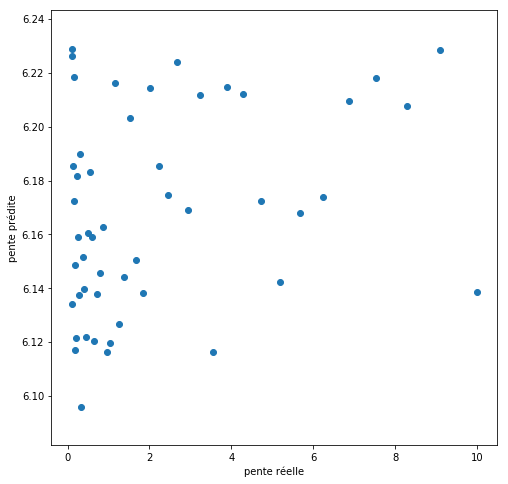

In [28]:
#wt prediction/generate 

wts = np.logspace(-1, 1, 50, base=10)
wt_s = []

for wt_ in wts:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)
        
    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        
    wt_pred = logistic_model.linear.weight.item()
        
    wt_s.append(wt_pred)
    print(f" wt:{wt_pred:.5f}") 
    
plt.figure(figsize = (8,8)) 
plt.scatter(wts, wt_s)
plt.xlabel('pente réelle')
plt.ylabel('pente prédite')
